In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import entropy
from sklearn.feature_selection import mutual_info_regression
from typing import Any

df = pd.read_csv("Laptop_price.csv")
df.head()

,Brand,Processor_Speed,RAM_Size,Storage_Capacity,Screen_Size,Weight,Price
0,Asus,3.830296,16,512,11.185147,2.641094,17395.093065
1,Acer,2.912833,4,1000,11.311372,3.260012,31607.605919
2,Lenovo,3.241627,4,256,11.853023,2.029061,9291.023542
3,Acer,3.806248,16,512,12.280360,4.573865,17436.728334
4,Acer,3.268097,32,1000,14.990877,4.193472,32917.990718


In [3]:
df.isnull().sum()

Brand               0
Processor_Speed     0
RAM_Size            0
Storage_Capacity    0
Screen_Size         0
Weight              0
Price               0
dtype: int64

In [4]:
encoded_data = pd.get_dummies(df, columns=['Brand'], prefix='Brand', drop_first=True)

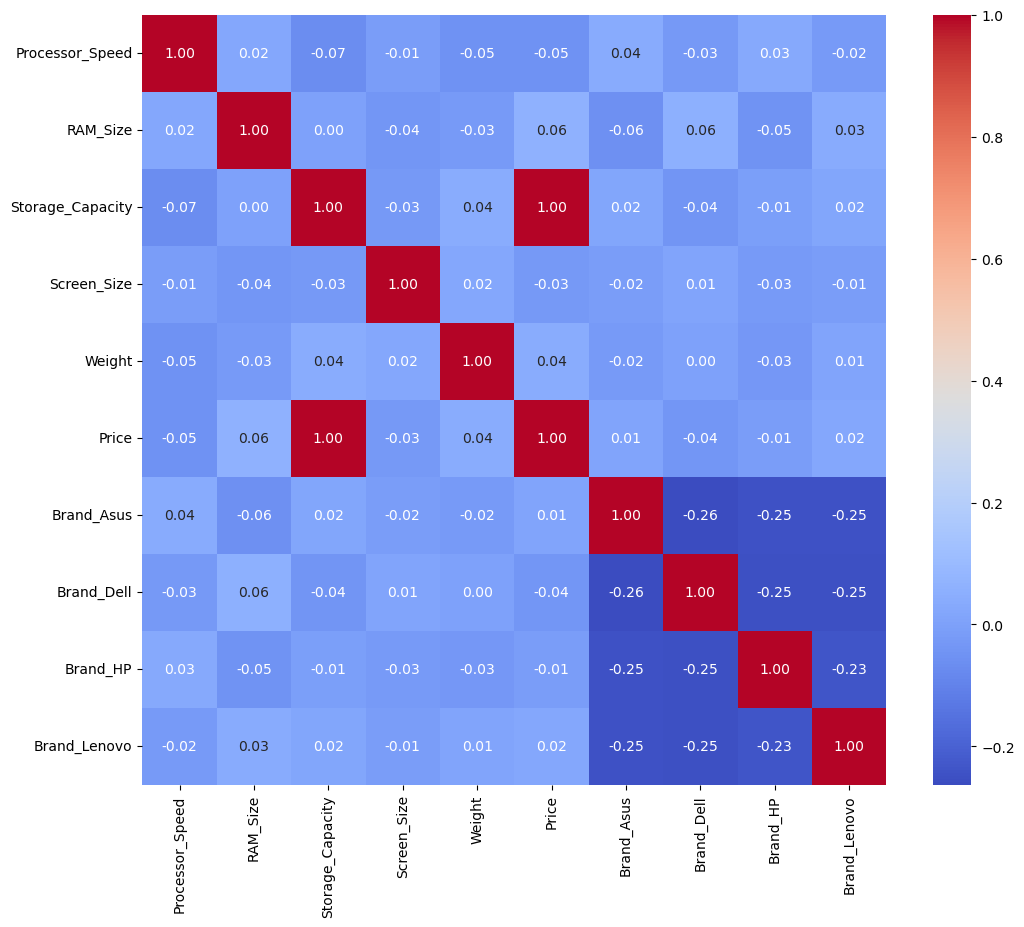

In [5]:
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(encoded_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")

In [7]:
target = "Price"

correlations = encoded_data.corr()[target].abs()
threshold = 0.3

selected_features = correlations[correlations > threshold].index.tolist()
print(selected_features)
selected_data = encoded_data[selected_features]
selected_data

['Storage_Capacity', 'Price']


,Storage_Capacity,Price
0,512,17395.093065
1,1000,31607.605919
2,256,9291.023542
3,512,17436.728334
4,1000,32917.990718
...,...,...
995,1000,31593.668017
996,256,9149.521832
997,512,16552.404779
998,256,9407.473459


In [10]:
x = encoded_data.drop([target], axis=1)
y = encoded_data[target]

<Axes: >

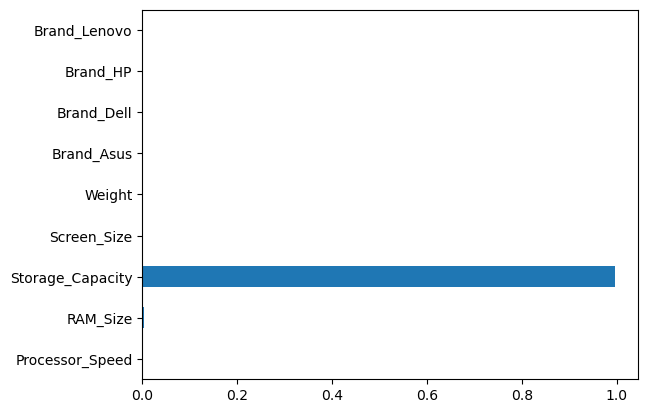

In [11]:
regr = RandomForestRegressor(max_depth=20, random_state=0)
regr.fit(x, y)
feat_importances = pd.Series(regr.feature_importances_, index=x.columns)
feat_importances.plot(kind='barh')

In [ ]:
encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Processor_Speed   1000 non-null   float64
 1   RAM_Size          1000 non-null   int64  
 2   Storage_Capacity  1000 non-null   int64  
 3   Screen_Size       1000 non-null   float64
 4   Weight            1000 non-null   float64
 5   Price             1000 non-null   float64
 6   Brand_Asus        1000 non-null   uint8  
 7   Brand_Dell        1000 non-null   uint8  
 8   Brand_HP          1000 non-null   uint8  
 9   Brand_Lenovo      1000 non-null   uint8  
dtypes: float64(4), int64(2), uint8(4)
memory usage: 50.9 KB


(array([355.,   2.,   0., 296.,  11.,   0.,   0.,   0.,   4., 332.]),
 array([ 8570.01295047, 11063.40515915, 13556.79736784, 16050.18957652,
        18543.58178521, 21036.97399389, 23530.36620258, 26023.75841126,
        28517.15061995, 31010.54282863, 33503.93503731]),
 <BarContainer object of 10 artists>)

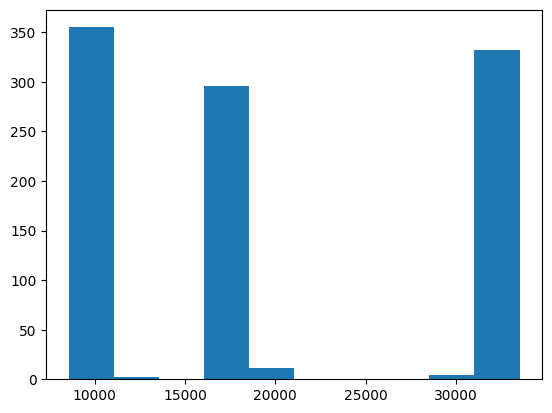

In [ ]:
plt.hist(encoded_data.Price)

Видим что наше ценообразование разбивается по сути на 3 группы, т.е можно представить задачу как задачу классификации по трем этим группам

In [12]:
def f(x) -> str:
  if x < 16000:
    return '1'
  elif x < 25000:
    return '2'
  else:
    return '3'


In [13]:
encoded_data["category"] = encoded_data[target].apply(f)

In [14]:
encoded_data

,Processor_Speed,RAM_Size,Storage_Capacity,Screen_Size,Weight,Price,Brand_Asus,Brand_Dell,Brand_HP,Brand_Lenovo,category
0,3.830296,16,512,11.185147,2.641094,17395.093065,True,False,False,False,2
1,2.912833,4,1000,11.311372,3.260012,31607.605919,False,False,False,False,3
2,3.241627,4,256,11.853023,2.029061,9291.023542,False,False,False,True,1
3,3.806248,16,512,12.280360,4.573865,17436.728334,False,False,False,False,2
4,3.268097,32,1000,14.990877,4.193472,32917.990718,False,False,False,False,3
...,...,...,...,...,...,...,...,...,...,...,...
995,3.343584,4,1000,12.587095,3.162399,31593.668017,False,False,True,False,3
996,2.780555,8,256,12.679356,3.750265,9149.521832,False,True,False,False,1
997,3.200569,4,512,12.666315,3.392612,16552.404779,False,True,False,False,2
998,1.604182,8,256,11.215581,3.857613,9407.473459,True,False,False,False,1


In [15]:
import pandas as pd
import numpy as np
from math import log2
from typing import List, Any, Dict, Tuple

def calculate_category_probabilities(x: pd.Series, category_col: str ="category") -> List[float]:
    categories = x[category_col].unique()
    probabilities = [x[x[category_col] == category].shape[0] / x.shape[0] for category in categories]
    return probabilities

def calc_entropy(p: List[float]) -> float:
    return sum([-p_i * log2(p_i) if p_i != 0 else 0 for p_i in p])

def gain_ratio(dataset: pd.DataFrame, target_col: str = "target", category_col: str = "category") -> Dict[Any, Tuple[float, float]]:
    x = dataset
    p = calculate_category_probabilities(x, category_col)
    h_x = calc_entropy(p)
    print(h_x)
    res = {}
    gain_ratio_value = 0

    for column in dataset.columns:
        max_gain_ratio = float("-inf")
        if column == target_col or column == category_col:
            continue

        best_value = float("-inf")
        for value in dataset[column].unique():
            x_l = dataset.loc[dataset[column] <= value]
            x_r = dataset.loc[dataset[column] > value]

            p_l = calculate_category_probabilities(x_l, category_col)
            p_r = calculate_category_probabilities(x_r, category_col)

            h_x_l = calc_entropy(p_l)
            h_x_r = calc_entropy(p_r)

            gain_ratio_value = h_x - (x_l.shape[0] / x.shape[0]) * h_x_l - (x_r.shape[0] / x.shape[0]) * h_x_r
            if gain_ratio_value > max_gain_ratio:
                max_gain_ratio = gain_ratio_value
                best_value = value
                res[column] = (best_value, gain_ratio_value)

    return res

In [17]:
encoded_data.head()


,Processor_Speed,RAM_Size,Storage_Capacity,Screen_Size,Weight,Price,Brand_Asus,Brand_Dell,Brand_HP,Brand_Lenovo,category
0,3.830296,16,512,11.185147,2.641094,17395.093065,True,False,False,False,2
1,2.912833,4,1000,11.311372,3.260012,31607.605919,False,False,False,False,3
2,3.241627,4,256,11.853023,2.029061,9291.023542,False,False,False,True,1
3,3.806248,16,512,12.280360,4.573865,17436.728334,False,False,False,False,2
4,3.268097,32,1000,14.990877,4.193472,32917.990718,False,False,False,False,3


In [18]:
features_with_gains = gain_ratio(encoded_data, target_col=target, category_col="category")
print(features_with_gains)
selected_gain_features = sorted(features_with_gains, key=lambda x: list(x)[1], reverse=True)
selected_gain_features



1.5822209588213898
{'Processor_Speed': (1.756274319976698, 0.00628883326073848), 'RAM_Size': (4, 0.000909335591757543), 'Storage_Capacity': (256, 0.9401647521318282), 'Screen_Size': (16.95017644023471, 0.006316797475793834), 'Weight': (2.004931271337349, 0.005964909828616305), 'Brand_Asus': (False, 0.0018516384746549153), 'Brand_Dell': (False, 0.0014558439647834875), 'Brand_HP': (False, 0.002017598825981737), 'Brand_Lenovo': (False, 0.0020357351369605925)}


['Storage_Capacity',
 'Processor_Speed',
 'Brand_Asus',
 'Brand_Dell',
 'Brand_HP',
 'Brand_Lenovo',
 'Weight',
 'Screen_Size',
 'RAM_Size']